First, lets import the required libraries:

In [1]:
import tensorflow as tf
import time
import codecs
import os
import collections
from six.moves import cPickle
import numpy as np
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#print(os.getcwd())
#print(os.listdir())
from datetime import datetime

print(os.stat('input.txt'))

mod_time = os.stat('input.txt').st_mtime

print(datetime.fromtimestamp(mod_time))

os.stat_result(st_mode=33204, st_ino=6839431323, st_dev=41, st_nlink=1, st_uid=1000, st_gid=2000, st_size=1115393, st_atime=1567160289, st_mtime=1567160289, st_ctime=1567170750)
2019-08-30 10:18:09.766575


Libraries
<ul>
    <li><b>os</b>: is an module that allows us to interact with the operating systerm, in particular we will use it to set the path in which we will be storing our input file, tensor file and vocab file</li>
    <li><b>time</b>: is a library that allows us to access the clock time of our machine, we will use it to measure the performance of training our model with a CPU, versus training our model with a GPU</li>
    <li><b>cPickle</b>: is a library for serializing and deserializing python objects, we will use the <b>dump()</b> method in cPickle to serialize our objects when saving them, and <b>load()</b> method in cPickle to deserialize our objects when loading.</li>
    <li><b>codec</b>: is a library that deals with character encoding, we will use the <b>open()</b> method as it is recommended when opening encoded text files.</li>
    <li><b>collections</b>: is a library that implements high performance container types, we will use the <b>Counter</b> object to get a collection of frequencies for our characters</li>
</ul>

<h3>Downloading the input data</h3>
Lets download the input file, and take a look at some parts of it:

In [3]:
!wget -nv -O input.txt https://ibm.box.com/shared/static/a3f9e9mbpup09toq35ut7ke3l3lf03hg.txt 
with open('input.txt', 'r') as f:
    read_data = f.read()
    print("-------------Sample text---------------")
    print (read_data[0:500])
    print("---------------------------------------")
f.closed

2019-08-30 13:17:09 URL:https://public.boxcloud.com/d/1/b1!YgTw2MrsGCRS-AakUwUc8OW7iX2DBvKnaeI9WlBvPoP1wqhJom2CisZ4KmDCezCPmkIpJE6sPgy772dldTVDLf2HTTaJPME_WnNZ_oxKRL69UZ1cxpnzwaIpzQ3Ztb_1p0qFOTTQwF482jp2f3v0sCGnpvYm2AfhNwrhiGzhj2fxzfsR5V-qJTfnmD065fP_Mo57LCnNz4WMGTgXvZOabcWYTTOAd-V4EvNQfh3ozKDptxr7_l5aWtFmFqIErcmZJ0uokCB6XdyIQqpHrRnr_kxneRXEtILYYJs4zOb_2_3ZCvqIP1Kk9qD0kD1N1j63Aw5bY1kwkktWQxaLLysk_v0jXqrgAa6tbyOjJALLWv_dNG7uanJwRzKIYY19IHEJKJCKBKIFQ4PMO-GIMZypz-dgVJWBt3DlFb4tAKthRsf11wzOh-q0pHFKgh_aao7rteNJvJFB4izz9MGV-INDw74ePPgbVUGVybV--tL2NdTGHIZJ_CURyXztDj-U8v0LopygpJnKGSOkkWO_Lkb8dVdbEAwf4HSKI-rNlSfVxz5VSkCbYsL4OFE9njKAQ3GPVf4AHXTG3rBzIi1d27RwtEmjH0ge4jS2HsiNMXINBv5O2XgsMcwnRgsugui8E2y0d1rfPTfoeQZWvgMtWmPga-LfMTpzl-P1su_8tHIO2qeole4I2iYGRJ-GCeNRt6qMKE2VZvxn77JnlpVAx-5JAdEGsTixyHfi_LGb5imzZxafbDJtwfTfhN5qKsNI1c-e1ce-2aFp0wDEoyqRJKQOTQkVx5PJdIX87Vzxnw_MgiUjOCVWiOsmjXsgavETRGIYSzd95JaRDxH8lEnJtwE5ZtuO6kyRtPZUcMKLR0EJuW2Dk4eM5ONZwjfqyWSliyjvMVsRk4ShYIG2a9lfp1wTCMjF60HImzN6aS9aaDcl9Ht2g

True

<h3>Data loader</h3>
One need to read the input file and convert each character to numerical values. The following cell is a class that helps to read data from input file.

In [4]:
class TextLoader():
    def __init__(self, data_dir, batch_size, seq_length, encoding='utf-8'):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.encoding = encoding

        input_file = os.path.join(data_dir, "input.txt")
        vocab_file = os.path.join(data_dir, "vocab.pkl")
        tensor_file = os.path.join(data_dir, "data.npy")

        if not (os.path.exists(vocab_file) and os.path.exists(tensor_file)):
            print("reading text file")
            self.preprocess(input_file, vocab_file, tensor_file)
        else:
            print("loading preprocessed files")
            self.load_preprocessed(vocab_file, tensor_file)
        self.create_batches()
        self.reset_batch_pointer()

    def preprocess(self, input_file, vocab_file, tensor_file):
        with codecs.open(input_file, "r", encoding=self.encoding) as f:
            data = f.read()
        counter = collections.Counter(data)
        count_pairs = sorted(counter.items(), key=lambda x: -x[1])
        self.chars, _ = zip(*count_pairs)
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(len(self.chars))))
        with open(vocab_file, 'wb') as f:
            cPickle.dump(self.chars, f)
        self.tensor = np.array(list(map(self.vocab.get, data)))
        np.save(tensor_file, self.tensor)

    def load_preprocessed(self, vocab_file, tensor_file):
        with open(vocab_file, 'rb') as f:
            self.chars = cPickle.load(f)
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(len(self.chars))))
        self.tensor = np.load(tensor_file)
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))

    def create_batches(self):
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))

        # When the data (tensor) is too small, let's give them a better error message
        if self.num_batches==0:
            assert False, "Not enough data. Make seq_length and batch_size small."

        self.tensor = self.tensor[:self.num_batches * self.batch_size * self.seq_length]
        xdata = self.tensor
        ydata = np.copy(self.tensor)
        ydata[:-1] = xdata[1:]
        ydata[-1] = xdata[0]
        self.x_batches = np.split(xdata.reshape(self.batch_size, -1), self.num_batches, 1)
        self.y_batches = np.split(ydata.reshape(self.batch_size, -1), self.num_batches, 1)


    def next_batch(self):
        x, y = self.x_batches[self.pointer], self.y_batches[self.pointer]
        self.pointer += 1
        return x, y

    def reset_batch_pointer(self):
        self.pointer = 0

<h3>Parameters</h3>

<p>We have to convert the characters in the string to numbers. Also we need to represent each sequence of characters as a vector in each batch.</p>
So, let's set some parameters that we need those now for reading the dataset, and later to build the model.

In [5]:
seq_length = 50 # RNN sequence length
batch_size = 128  # minibatch size, i.e. size of data in each epoch
num_epochs = 50 # one should change it to 50 if relatively good results are desired
learning_rate = 0.002
decay_rate = 0.97
rnn_size = 128 # size of RNN hidden state (output dimension)
num_layers = 2 #number of layers in the RNN

<p>Now, we can read the data at batches using the <b>TextLoader</b> class. It will convert the characters to numbers, and represent each sequence as a vector in batches:</p>

In [6]:
data_loader = TextLoader('', batch_size, seq_length)
vocab_size = data_loader.vocab_size
print ("vocabulary size:" ,data_loader.vocab_size)
print ("Characters:" ,data_loader.chars)
print ("vocab number of 'F':",data_loader.vocab['F'])
print ("Character sequences (first batch):", data_loader.x_batches[0])

loading preprocessed files
vocabulary size: 65
Characters: (' ', 'e', 't', 'o', 'a', 'h', 's', 'r', 'n', 'i', '\n', 'l', 'd', 'u', 'm', 'y', ',', 'w', 'f', 'c', 'g', 'I', 'b', 'p', ':', '.', 'A', 'v', 'k', 'T', "'", 'E', 'O', 'N', 'R', 'S', 'L', 'C', ';', 'W', 'U', 'H', 'M', 'B', '?', 'G', '!', 'D', '-', 'F', 'Y', 'P', 'K', 'V', 'j', 'q', 'x', 'z', 'J', 'Q', 'Z', 'X', '3', '&', '$')
vocab number of 'F': 49
Character sequences (first batch): [[49  9  7 ...  1  4  7]
 [39  5  3 ...  0 20  9]
 [ 0  5  9 ... 19  4 13]
 ...
 [ 3 18 18 ...  1  0 23]
 [ 7  1 23 ... 18  3  7]
 [47 26 24 ...  0  8  3]]


<b>Notice:</b> In the following cells, we just go through the process of defining each element of the LSTM, and explore the inputs, outputs of each layer. Then, we put all together and run the network.

<h3>1- Input and Output</h3>
In the next cell we just take a look at a sample batch to underestand the data better. Each batch includes the input, <b>x</b>, and the character that we want to predict, <b>y</b>:

In [7]:
x, y = data_loader.next_batch()
x

array([[49,  9,  7, ...,  1,  4,  7],
       [39,  5,  3, ...,  0, 20,  9],
       [ 0,  5,  9, ..., 19,  4, 13],
       ...,
       [ 3, 18, 18, ...,  1,  0, 23],
       [ 7,  1, 23, ..., 18,  3,  7],
       [47, 26, 24, ...,  0,  8,  3]])

In [8]:
x.shape  #batch_size =128, seq_length=50

(128, 50)

Here, y is the next character for each character in x:

In [9]:
y

array([[ 9,  7,  6, ...,  4,  7,  0],
       [ 5,  3,  0, ..., 20,  9, 27],
       [ 5,  9, 14, ...,  4, 13, 20],
       ...,
       [18, 18,  9, ...,  0, 23, 11],
       [ 1, 23,  3, ...,  3,  7,  0],
       [26, 24, 10, ...,  8,  3,  2]])

<h3>3- Defining stacked RNN Cell</h3>

<b>BasicRNNCell</b> is the most basic RNN cell.

In [10]:
# to define a LSTM cell
cell = tf.contrib.rnn.BasicRNNCell(rnn_size)
# a two layer cell
stacked_cell = tf.contrib.rnn.MultiRNNCell([cell] * num_layers)
# hidden state size
stacked_cell.output_size

128

<b>state</b> variable keeps output and new_state of the LSTM, so it is double in size:

In [11]:
stacked_cell.state_size

(128, 128)

Lets define the input data:

In [12]:
input_data = tf.placeholder(tf.int32, [batch_size, seq_length])# a 128x50
input_data

<tf.Tensor 'Placeholder:0' shape=(128, 50) dtype=int32>

and target data, what we want to predict:

In [13]:
targets = tf.placeholder(tf.int32, [batch_size, seq_length]) # a 128x50
targets

<tf.Tensor 'Placeholder_1:0' shape=(128, 50) dtype=int32>

The memory state of the network is initialized with a vector of zeros and gets updated after reading each character.

<b>BasicRNNCell.zero_state(batch_size, dtype)</b> Return zero-filled state tensor(s). In this function, batch_size
representing the batch size.

In [14]:
initial_state = stacked_cell.zero_state(batch_size, tf.float32) 
initial_state

(<tf.Tensor 'MultiRNNCellZeroState/BasicRNNCellZeroState/zeros:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'MultiRNNCellZeroState/BasicRNNCellZeroState_1/zeros:0' shape=(128, 128) dtype=float32>)

Lets check the value of the input_data again:

In [15]:
session = tf.Session(config=config)
feed_dict={input_data:x, targets:y}
session.run(input_data, feed_dict)

array([[49,  9,  7, ...,  1,  4,  7],
       [39,  5,  3, ...,  0, 20,  9],
       [ 0,  5,  9, ..., 19,  4, 13],
       ...,
       [ 3, 18, 18, ...,  1,  0, 23],
       [ 7,  1, 23, ..., 18,  3,  7],
       [47, 26, 24, ...,  0,  8,  3]], dtype=int32)

<h3>4- Embedding</h3>
<p>In this section, we build a 128-dim vector for each character. As we have 60 batches, and 50 character in each sequence, it will generate a [60,50,128] matrix.</p>

<p><b>Notice:</b> The function <code>tf.get_variable()</code> is used to share a variable and to initialize it in one place. <code>tf.get_variable()</code> is used to get or create a variable instead of a direct call to <code>tf.Variable</code>.</p>

In [16]:
with tf.variable_scope('rnnlm', reuse=False):
    softmax_w = tf.get_variable("softmax_w", [rnn_size, vocab_size]) #128x65
    softmax_b = tf.get_variable("softmax_b", [vocab_size]) # 1x65)
    #with tf.device("/cpu:0"):
        
    # embedding variable is initialized randomely
    embedding = tf.get_variable("embedding", [vocab_size, rnn_size])  #65x128

    # embedding_lookup goes to each row of input_data, and for each character in the row, finds the correspond vector in embedding
    # it creates a 60*50*[1*128] matrix
    # so, the first elemnt of em, is a matrix of 50x128, which each row of it is vector representing that character
    em = tf.nn.embedding_lookup(embedding, input_data) # em is 60x50x[1*128]
    # split: Splits a tensor into sub tensors.
    # syntax:  tf.split(split_dim, num_split, value, name='split')
    # it will split the 60x50x[1x128] matrix into 50 matrix of 60x[1*128]
    inputs = tf.split(em, seq_length, 1)
    # It will convert the list to 50 matrix of [60x128]
    inputs = [tf.squeeze(input_, [1]) for input_ in inputs]

Lets take a look at the <b>embedding</b>, <b>em</b>, and <b>inputs</b> variables:

Embedding variable is initialized with random values:

In [17]:
session.run(tf.global_variables_initializer())
#print embedding.shape
session.run(embedding)

array([[ 0.04869516, -0.17132466,  0.08786125, ...,  0.09496872,
        -0.03553957, -0.06146944],
       [ 0.06587443,  0.17524244, -0.13502207, ..., -0.11538697,
        -0.12743324,  0.17174132],
       [-0.1613645 , -0.02943245, -0.1473983 , ...,  0.14757879,
        -0.12204084, -0.01753469],
       ...,
       [-0.17368922, -0.164241  ,  0.17366342, ...,  0.04329385,
         0.03827263,  0.02882816],
       [-0.11447039,  0.09980626, -0.00347814, ...,  0.05745204,
        -0.02564628,  0.05669166],
       [-0.02557629, -0.04158674, -0.14265817, ...,  0.04142044,
        -0.03934956,  0.1581928 ]], dtype=float32)

The first elemnt of em, is a matrix of 50x128, which each row of it is vector representing that character

In [18]:
em = tf.nn.embedding_lookup(embedding, input_data)
emp = session.run(em,feed_dict={input_data:x})
print (emp.shape)
emp[0]

(128, 50, 128)


array([[ 0.00936982,  0.01546817, -0.07208177, ...,  0.07416238,
        -0.06070516, -0.07181732],
       [-0.13115823,  0.03976522, -0.15710235, ..., -0.1414805 ,
         0.11360596, -0.01539102],
       [-0.10667104, -0.06048652, -0.05224667, ...,  0.09774043,
         0.12739457,  0.16572614],
       ...,
       [ 0.06587443,  0.17524244, -0.13502207, ..., -0.11538697,
        -0.12743324,  0.17174132],
       [ 0.0109137 ,  0.13604014,  0.12487151, ...,  0.05502316,
         0.141964  ,  0.16444208],
       [-0.10667104, -0.06048652, -0.05224667, ...,  0.09774043,
         0.12739457,  0.16572614]], dtype=float32)

<p>Let's consider each sequence as a sentence of length 50 characters, then, the first item in <b>inputs</b> is a [60x128] vector which represents the first characters of 60 sentences.</p>

In [19]:
inputs = tf.split(em, seq_length, 1)
inputs = [tf.squeeze(input_, [1]) for input_ in inputs]
inputs[0:5]

[<tf.Tensor 'Squeeze:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'Squeeze_1:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'Squeeze_2:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'Squeeze_3:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'Squeeze_4:0' shape=(128, 128) dtype=float32>]

<h3>5- Feeding a batch of 50 sequence to a RNN:</h3>

The feeding process for inputs is as following:
<ul>
    <li>Step 1: first character of each of the 50 sentences (in a batch) is entered in parallel.</li>  
    <li>Step 2: second character of each of the 50 sentences is input in parallel.</li> 
    <li>Step n: nth character of each of the 50 sentences is input in parallel.</li>  
</ul>
<p>The parallelism is only for efficiency. Each character in a batch is handled in parallel, but the network sees one character of a sequence at a time and does the computations accordingly. All the computations involving the characters of all sequences in a batch at a given time step are done in parallel.</p>

In [20]:
session.run(inputs[0],feed_dict={input_data:x})

array([[ 0.00936982,  0.01546817, -0.07208177, ...,  0.07416238,
        -0.06070516, -0.07181732],
       [-0.00204353,  0.11974736, -0.10595191, ...,  0.01319008,
        -0.16712162,  0.08638029],
       [ 0.04869516, -0.17132466,  0.08786125, ...,  0.09496872,
        -0.03553957, -0.06146944],
       ...,
       [ 0.12801419,  0.09182973, -0.12704049, ...,  0.00563568,
         0.16816036,  0.11782263],
       [-0.10667104, -0.06048652, -0.05224667, ...,  0.09774043,
         0.12739457,  0.16572614],
       [-0.17107163,  0.0318604 ,  0.01951259, ..., -0.0433607 ,
        -0.1358027 , -0.1721824 ]], dtype=float32)

Feeding the RNN with one batch, we can check the new output and new state of network:

In [21]:
#outputs is 50x[60*128]
outputs, new_state = tf.contrib.legacy_seq2seq.rnn_decoder(inputs, initial_state, stacked_cell, loop_function=None, scope='rnnlm')
new_state

(<tf.Tensor 'rnnlm_1/rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/Tanh_98:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'rnnlm_1/rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/Tanh_99:0' shape=(128, 128) dtype=float32>)

In [22]:
outputs[0:5]

[<tf.Tensor 'rnnlm_1/rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/Tanh_1:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'rnnlm_1/rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/Tanh_3:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'rnnlm_1/rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/Tanh_5:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'rnnlm_1/rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/Tanh_7:0' shape=(128, 128) dtype=float32>,
 <tf.Tensor 'rnnlm_1/rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/Tanh_9:0' shape=(128, 128) dtype=float32>]

Let's check the output of network after feeding it with first batch:

In [23]:
first_output = outputs[0]
session.run(tf.global_variables_initializer())
session.run(first_output,feed_dict={input_data:x})

array([[-0.02469741, -0.01459357, -0.06040001, ..., -0.02076126,
         0.08457284,  0.04603299],
       [ 0.00202414,  0.03962038, -0.04982498, ..., -0.03215291,
         0.05855769,  0.15409017],
       [-0.12518369, -0.08340981, -0.06193903, ..., -0.03262179,
        -0.01758838,  0.06998984],
       ...,
       [ 0.06690809, -0.09092592, -0.06852615, ..., -0.03115801,
         0.01808828,  0.05549588],
       [ 0.04016316,  0.00270185, -0.0698784 , ...,  0.01396697,
         0.03011952,  0.12149755],
       [ 0.06099113, -0.0573225 , -0.00505273, ...,  0.0149193 ,
        -0.00032446, -0.06432496]], dtype=float32)

<p>As it was explained, <b>outputs</b> variable is a 50x[60x128] tensor. We need to reshape it back to [60x50x128] to be able to calculate the probablity of the next character using the softmax. The <b>softmax_w</b> shape is [rnn_size, vocab_size], which is [128x65] in our case. Therefore, we have a fully connected layer on top of LSTM cells, which help us to decode the next charachter. We can use the <b>softmax(output * softmax_w + softmax_b)</b> for this purpose. The shape of the matrixis would be:</p>

softmax([60x50x128]x[128x65]+[1x65]) = [60x50x65]

We can do it step-by-step:

In [24]:
output = tf.reshape(tf.concat( outputs,1), [-1, rnn_size])
output

<tf.Tensor 'Reshape:0' shape=(6400, 128) dtype=float32>

In [25]:
logits = tf.matmul(output, softmax_w) + softmax_b
logits

<tf.Tensor 'add:0' shape=(6400, 65) dtype=float32>

In [26]:
probs = tf.nn.softmax(logits)
probs

<tf.Tensor 'Softmax:0' shape=(6400, 65) dtype=float32>

Here is the probablity of the next chracter in all batches:

In [27]:
session.run(tf.global_variables_initializer())
session.run(probs,feed_dict={input_data:x})

array([[0.01870732, 0.01603062, 0.01389957, ..., 0.01622879, 0.01580931,
        0.01530458],
       [0.01333357, 0.01883012, 0.01454788, ..., 0.01515247, 0.02155875,
        0.01603586],
       [0.01759003, 0.01856367, 0.01459633, ..., 0.01566401, 0.01704178,
        0.01834561],
       ...,
       [0.01429179, 0.01391493, 0.01814258, ..., 0.01736828, 0.02144393,
        0.0133232 ],
       [0.02329761, 0.01759953, 0.01408618, ..., 0.01122731, 0.01238288,
        0.01765132],
       [0.01244864, 0.01383867, 0.01656101, ..., 0.02109144, 0.01805137,
        0.01753136]], dtype=float32)

Now, we are in the position to calculate the cost of training with <b>loss function</b>, and keep feeding the network to learn it. 

In [28]:
grad_clip =5.
tvars = tf.trainable_variables()
tvars

[<tf.Variable 'rnnlm/softmax_w:0' shape=(128, 65) dtype=float32_ref>,
 <tf.Variable 'rnnlm/softmax_b:0' shape=(65,) dtype=float32_ref>,
 <tf.Variable 'rnnlm/embedding:0' shape=(65, 128) dtype=float32_ref>,
 <tf.Variable 'rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/kernel:0' shape=(256, 128) dtype=float32_ref>,
 <tf.Variable 'rnnlm/multi_rnn_cell/cell_0/basic_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>]

Okay, by now, you should understand enough about each component of a LSTM network to be able to train it, and predict the next word. 

<h2>All together</h2>
Now, let's put all of parts together in a class, and train the model:

In [29]:
class LSTMModel():
    def __init__(self,sample=False, device='/cpu:0'):
        rnn_size = 128 # size of RNN hidden state vector
        batch_size = 128 # minibatch size, i.e. size of dataset in each epoch
        seq_length = 50 # RNN sequence length
        num_layers = 2 # number of layers in the RNN
        vocab_size = 65
        grad_clip = 5.
        if sample:
            batch_size = 1
            seq_length = 1
        with tf.device(device):
            # The core of the model consists of an LSTM cell that processes one char at a time and computes probabilities of the possible continuations of the char. 
            basic_cell = tf.contrib.rnn.BasicRNNCell(rnn_size)
            # model.cell.state_size is (128, 128)
            self.stacked_cell = tf.contrib.rnn.MultiRNNCell([basic_cell] * num_layers)

            self.input_data = tf.placeholder(tf.int32, [batch_size, seq_length], name="input_data")
            self.targets = tf.placeholder(tf.int32, [batch_size, seq_length], name="targets")
            # Initial state of the LSTM memory.
            # The memory state of the network is initialized with a vector of zeros and gets updated after reading each char. 
            self.initial_state = stacked_cell.zero_state(batch_size, tf.float32) #why batch_size

            with tf.variable_scope('rnnlm_class1'):
                softmax_w = tf.get_variable("softmax_w", [rnn_size, vocab_size]) #128x65
                softmax_b = tf.get_variable("softmax_b", [vocab_size]) # 1x65
                embedding = tf.get_variable("embedding", [vocab_size, rnn_size])  #65x128
                inputs = tf.split(tf.nn.embedding_lookup(embedding, self.input_data), seq_length, 1)
                inputs = [tf.squeeze(input_, [1]) for input_ in inputs] 

            # The value of state is updated after processing each batch of chars.
            outputs, last_state = tf.contrib.legacy_seq2seq.rnn_decoder(inputs, self.initial_state, self.stacked_cell, loop_function=None, scope='rnnlm_class1')
            output = tf.reshape(tf.concat(outputs,1), [-1, rnn_size])
            self.logits = tf.matmul(output, softmax_w) + softmax_b
            self.probs = tf.nn.softmax(self.logits)
            loss = tf.contrib.legacy_seq2seq.sequence_loss_by_example([self.logits],
                    [tf.reshape(self.targets, [-1])],
                    [tf.ones([batch_size * seq_length])],
                    vocab_size)
            self.cost = tf.reduce_sum(loss) / batch_size / seq_length
            self.final_state = last_state
            self.lr = tf.Variable(0.0, trainable=False)
            tvars = tf.trainable_variables()
            grads, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tvars),grad_clip)
            optimizer = tf.train.AdamOptimizer(self.lr)
            self.train_op = optimizer.apply_gradients(zip(grads, tvars))

    
    def sample(self, sess, chars, vocab, num=200, prime='The ', sampling_type=1):
        state = sess.run(self.stacked_cell.zero_state(1, tf.float32))
        #print state
        for char in prime[:-1]:
            x = np.zeros((1, 1))
            x[0, 0] = vocab[char]
            feed = {self.input_data: x, self.initial_state:state}
            [state] = sess.run([self.final_state], feed)

        def weighted_pick(weights):
            t = np.cumsum(weights)
            s = np.sum(weights)
            return(int(np.searchsorted(t, np.random.rand(1)*s)))

        ret = prime
        char = prime[-1]
        for n in range(num):
            x = np.zeros((1, 1))
            x[0, 0] = vocab[char]
            feed = {self.input_data: x, self.initial_state:state}
            [probs, state] = sess.run([self.probs, self.final_state], feed)
            p = probs[0]

            if sampling_type == 0:
                sample = np.argmax(p)
            elif sampling_type == 2:
                if char == ' ':
                    sample = weighted_pick(p)
                else:
                    sample = np.argmax(p)
            else: # sampling_type == 1 default:
                sample = weighted_pick(p)

            pred = chars[sample]
            ret += pred
            char = pred
        return ret

<a id="cpu_vs_gpu"></a>
<h2>Train the model using CPU and GPU</h2>
We can train our model through feeding batches.

<a id="question_1"></a>
<h2>Code to run it on CPU</h2>

In [31]:
avg_batch_running_duration_CPU=[]
tf.reset_default_graph()


with tf.variable_scope("rnn_CPU"):
    model = LSTMModel(device='/cpu:0')
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(num_epochs): # num_epochs is 20 for test, but should be higher
            sess.run(tf.assign(model.lr, learning_rate * (decay_rate ** e)))
            ##  code below to reset the batch pointer in data_loader. 
            data_loader.reset_batch_pointer()
            state = sess.run(model.initial_state) # model initialization
            batch_running_duration_CPU = []
            for b in range(data_loader.num_batches): #for each batch
                start = time.time()
                ## code to define your x and y. 
                x, y = data_loader.next_batch()
                feed = {model.input_data: x, model.targets: y, model.initial_state:state}

                ## code to train the model
                train_loss, state, _ = sess.run([model.cost, model.final_state, model.train_op],feed)

                end = time.time()

                ## code to store the duration of runing each batch in a list (end - start)
                batch_running_duration_CPU.append(end - start)
        
            print("{}/{} (epoch {}), train_loss = {:.3f}, time/batch = {:.3f}" \
                    .format(e * data_loader.num_batches + b, num_epochs * data_loader.num_batches, e, train_loss, end - start))
            avg_batch_running_duration_CPU.append(sum(batch_running_duration_CPU) / float(len(batch_running_duration_CPU)))

            # To see the sample of prediction
#            with tf.variable_scope("rnn_CPU", reuse=True):
#                  sample_model = LSTMModel(sample=True)
#                  print ('----------------------------------')
#                  print ('SAMPLE GENERATED TEXT:')
#                  print (sample_model.sample(sess, data_loader.chars , data_loader.vocab, num=150, prime='The ', sampling_type=1))
#                  print ('----------------------------------')

173/8700 (epoch 0), train_loss = 2.082, time/batch = 0.111
347/8700 (epoch 1), train_loss = 1.874, time/batch = 0.113
521/8700 (epoch 2), train_loss = 1.762, time/batch = 0.080
695/8700 (epoch 3), train_loss = 1.691, time/batch = 0.115
869/8700 (epoch 4), train_loss = 1.642, time/batch = 0.116
1043/8700 (epoch 5), train_loss = 1.606, time/batch = 0.111
1217/8700 (epoch 6), train_loss = 1.580, time/batch = 0.115
1391/8700 (epoch 7), train_loss = 1.559, time/batch = 0.115
1565/8700 (epoch 8), train_loss = 1.538, time/batch = 0.083
1739/8700 (epoch 9), train_loss = 1.522, time/batch = 0.114
1913/8700 (epoch 10), train_loss = 1.509, time/batch = 0.113
2087/8700 (epoch 11), train_loss = 1.498, time/batch = 0.115
2261/8700 (epoch 12), train_loss = 1.488, time/batch = 0.120
2435/8700 (epoch 13), train_loss = 1.480, time/batch = 0.113
2609/8700 (epoch 14), train_loss = 1.472, time/batch = 0.109
2783/8700 (epoch 15), train_loss = 1.466, time/batch = 0.116
2957/8700 (epoch 16), train_loss = 1.46

<a id="question_2"></a>
<h2>Code to run it on GPU</h2>
Now, the same network with GPU, and the time/batch for running each batch is calculated

In [32]:
### Create the same network using GPU


avg_batch_running_duration_GPU=[]
tf.reset_default_graph()


with tf.variable_scope("rnn_GPU"):
    model = LSTMModel(device='/gpu:0')
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(num_epochs): # num_epochs is 20 for test, but should be higher
            sess.run(tf.assign(model.lr, learning_rate * (decay_rate ** e)))
            ##  code below to reset the batch pointer in data_loader. 
            data_loader.reset_batch_pointer()
            state = sess.run(model.initial_state) # model initialization
            batch_running_duration_GPU = []
            for b in range(data_loader.num_batches): #for each batch
                start = time.time()
                ## code to define your x and y. 
                x, y = data_loader.next_batch()
                feed = {model.input_data: x, model.targets: y, model.initial_state:state}

                feed = {model.input_data: x, model.targets: y, model.initial_state:state}            

                ## code to train the model
                train_loss, state, _ = sess.run([model.cost, model.final_state, model.train_op],feed)


                end = time.time()

                ## code to store the duration of runing each batch in a list (end - start)
                batch_running_duration_GPU.append(end - start)


            print("{}/{} (epoch {}), train_loss = {:.3f}, time/batch = {:.3f}" \
                    .format(e * data_loader.num_batches + b, num_epochs * data_loader.num_batches, e, train_loss, end - start))
            avg_batch_running_duration_GPU.append(sum(batch_running_duration_GPU) / float(len(batch_running_duration_GPU)))

            # To see the sample of prediction
#            with tf.variable_scope("rnn_GPU", reuse=True):
#                  sample_model = LSTMModel(sample=True)
#                  print ('----------------------------------')
#                  print ('SAMPLE GENERATED TEXT:')
#                  print (sample_model.sample(sess, data_loader.chars , data_loader.vocab, num=200, prime='The ', sampling_type=1))
#                  print ('----------------------------------')



173/8700 (epoch 0), train_loss = 2.060, time/batch = 0.019
347/8700 (epoch 1), train_loss = 1.851, time/batch = 0.020
521/8700 (epoch 2), train_loss = 1.741, time/batch = 0.020
695/8700 (epoch 3), train_loss = 1.674, time/batch = 0.019
869/8700 (epoch 4), train_loss = 1.630, time/batch = 0.019
1043/8700 (epoch 5), train_loss = 1.598, time/batch = 0.021
1217/8700 (epoch 6), train_loss = 1.572, time/batch = 0.019
1391/8700 (epoch 7), train_loss = 1.552, time/batch = 0.022
1565/8700 (epoch 8), train_loss = 1.536, time/batch = 0.018
1739/8700 (epoch 9), train_loss = 1.522, time/batch = 0.021
1913/8700 (epoch 10), train_loss = 1.511, time/batch = 0.018
2087/8700 (epoch 11), train_loss = 1.502, time/batch = 0.019
2261/8700 (epoch 12), train_loss = 1.494, time/batch = 0.021
2435/8700 (epoch 13), train_loss = 1.487, time/batch = 0.020
2609/8700 (epoch 14), train_loss = 1.480, time/batch = 0.021
2783/8700 (epoch 15), train_loss = 1.474, time/batch = 0.020
2957/8700 (epoch 16), train_loss = 1.46

<a id="question_3"></a>
<h2>Compare the results</h2>
Finally, using a graph, the speed of training (batch/time) for the model running on GPU and CPU is shown here:

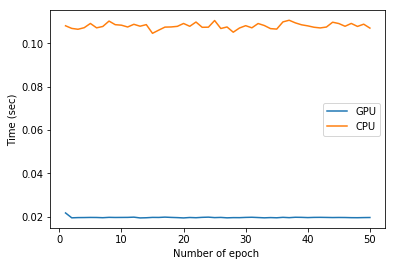

<Figure size 432x288 with 0 Axes>

In [35]:
# Lets plot the performance of training the model on a CPU versus on a GPU.

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot(list(range(1,len(avg_batch_running_duration_GPU)+1)), avg_batch_running_duration_GPU, label='GPU')
plt.plot(list(range(1,len(avg_batch_running_duration_CPU)+1)), avg_batch_running_duration_CPU, label='CPU')
plt.ylabel('Time (sec)')
plt.xlabel('Number of epoch ')
plt.legend(loc='best')
plt.show()


<hr>
